In [3]:
! pip install torch tqdm
#! pip install --upgrade git+https://github.com/rimgro/biocadprotein.git

You should consider upgrading via the 'C:\Users\User\Desktop\biocadprotein\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
torch.manual_seed(12)
np.random.seed(12)

<h3>Подготовка данных</h3>

In [6]:
from fpgen.prop_prediction.dataset import FPbase
from fpgen.prop_prediction.metrics import get_regression_metrics
from torch.utils.data import TensorDataset, DataLoader

In [7]:
dataset = FPbase('data/fpbase.csv')

# one-hot encoding setup
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
vocab = {aa: i for i, aa in enumerate(amino_acids)}

In [8]:
x_train, y_train = dataset.get_train('em_max')
from sklearn.model_selection import train_test_split

# Split training data into train and validation sets (e.g., 80% train, 20% val)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

x_test, y_test = dataset.get_test('em_max')

In [9]:
def encode_sequences(sequences, vocab, max_length=None):
    """
    One-hot encode protein sequences
    
    Args:
        sequences: List of protein sequences (strings)
        vocab: Amino acid vocabulary dictionary (only used for consistency)
        max_length: Maximum sequence length (will pad/truncate)
    
    Returns:
        One-hot encoded sequences as torch tensor of shape (num_sequences, max_length, 20)
    """
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)
    
    # Standard 20 amino acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
    
    encoded = []
    for seq in sequences:
        # Initialize one-hot matrix for this sequence
        seq_onehot = torch.zeros(max_length, 20)
        
        # Convert to uppercase and encode each amino acid
        seq_upper = seq.upper()
        for i, aa in enumerate(seq_upper):
            if i >= max_length:
                break
            if aa in aa_to_idx:
                seq_onehot[i, aa_to_idx[aa]] = 1.0
            # If amino acid is not in standard 20, leave as zeros (unknown)
        
        encoded.append(seq_onehot)
    
    return torch.stack(encoded)

<h3>Преобразование в one-hot encoding</h3>

In [10]:
x_train_encoded = encode_sequences(x_train, vocab)
x_val_encoded = encode_sequences(x_val, vocab)
x_test_encoded = encode_sequences(x_test, vocab)

In [11]:
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [12]:
dataset_train = TensorDataset(x_train_encoded, y_train_tensor)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
    
dataset_val = TensorDataset(x_val_encoded, y_val_tensor)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
    
dataset_test = TensorDataset(x_test_encoded, y_test_tensor)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# Доготовка данных для работы с embeddings ESM C

In [10]:
import pickle

with open('../data/sequence.pickle', 'rb') as file:
    seq = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '../data/sequence.pickle'

In [ ]:
seq[x_train.iloc[0]].shape

torch.Size([1, 236, 960])

In [ ]:
def preprocessing_x(x_tr, x_t, x_v, seq, pad_value=0.0, max_length=None):
    """
    Improved preprocessing function for LSTM training with ESM embeddings
    
    Args:
        x_tr, x_t, x_v: Index arrays for train, test, val
        seq: Dictionary/list containing the embeddings
        pad_value: Value to use for padding (default: 0.0)
        max_length: Maximum sequence length (if None, computed from data)
    """
    
    def get_cleaned_tensors(indexes):
        cleaned = []
        for i in range(len(indexes)):
            tensor = seq[indexes.iloc[i]]  # shape: [1, L, D]
            
            # Handle different input shapes
            if tensor.dim() == 3 and tensor.shape[0] == 1:
                tensor = tensor.squeeze(0)  # Now shape: [L, D]
            elif tensor.dim() == 2:
                pass  # Already correct shape
            else:
                raise ValueError(f"Unexpected tensor shape: {tensor.shape}")
            
            # Ensure tensor is float and on CPU for consistent processing
            tensor = tensor.float()
            
            # Basic validation
            if tensor.shape[0] == 0:
                raise ValueError("Found empty sequence")
            if torch.isnan(tensor).any() or torch.isinf(tensor).any():
                print(f"Warning: Found NaN/Inf values in tensor, replacing with zeros")
                tensor = torch.nan_to_num(tensor, nan=0.0, posinf=1.0, neginf=-1.0)
            
            cleaned.append(tensor)
        return cleaned

    # Extract cleaned tensors
    matrix_tr = get_cleaned_tensors(x_tr)
    matrix_t = get_cleaned_tensors(x_t)
    matrix_v = get_cleaned_tensors(x_v)

    # Find dimensions
    all_tensors = matrix_tr + matrix_t + matrix_v
    
    # Check embedding dimension consistency
    emb_dims = [t.shape[1] for t in all_tensors]
    emb_dim = emb_dims[0]
    if not all(d == emb_dim for d in emb_dims):
        raise ValueError(f"Inconsistent embedding dimensions: {set(emb_dims)}")
    
    # Find max length
    if max_length is None:
        max_len = max(t.shape[0] for t in all_tensors)
    else:
        max_len = max_length
    
    print(f"Max sequence length: {max_len}")
    print(f"Embedding dimension: {emb_dim}")
    print(f"Padding value: {pad_value}")

    def pad_tensor_list(tensor_list, split_name):
        padded = []
        original_lengths = []
        
        for i, t in enumerate(tensor_list):
            seq_len = t.shape[0]
            original_lengths.append(seq_len)
            
            if seq_len > max_len:
                # Truncate if longer than max_len
                t = t[:max_len]
                seq_len = max_len
            
            # Pad sequence length dimension only (embedding dim should be consistent)
            if seq_len < max_len:
                padding = (0, 0, 0, max_len - seq_len)  # (left, right, top, bottom)
                padded_tensor = F.pad(t, padding, mode='constant', value=pad_value)
            else:
                padded_tensor = t
            
            padded.append(padded_tensor)
        
        # Stack into batch
        result = torch.stack(padded)
        
        # Validation
        expected_shape = (len(tensor_list), max_len, emb_dim)
        if result.shape != expected_shape:
            raise ValueError(f"Unexpected output shape for {split_name}: {result.shape}, expected: {expected_shape}")
        
        print(f"{split_name} - Shape: {result.shape}, Lengths: min={min(original_lengths)}, max={max(original_lengths)}, mean={np.mean(original_lengths):.1f}")
        
        return result, original_lengths

    # Process all splits
    train, train_lengths = pad_tensor_list(matrix_tr, "Train")
    test, test_lengths = pad_tensor_list(matrix_t, "Test")
    val, val_lengths = pad_tensor_list(matrix_v, "Val")
    
    # Additional validation
    def validate_output(tensor, name):
        if torch.isnan(tensor).any():
            raise ValueError(f"NaN values found in {name}")
        if torch.isinf(tensor).any():
            raise ValueError(f"Inf values found in {name}")
        
        # Check if too many zeros (might indicate padding issues)
        zero_ratio = (tensor == pad_value).float().mean()
        if zero_ratio > 0.8:
            print(f"Warning: {name} has {zero_ratio:.2%} zero values (heavy padding)")
    
    validate_output(train, "train")
    validate_output(test, "test")
    validate_output(val, "val")
    
    return train, test, val

In [ ]:
def pad_with_last_token(tensor, target_length):
    """Pad by repeating the last token instead of zeros"""
    seq_len = tensor.shape[0]
    if seq_len >= target_length:
        return tensor[:target_length]
    
    last_token = tensor[-1:].repeat(target_length - seq_len, 1)
    return torch.cat([tensor, last_token], dim=0)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

x_train_p, x_val_p, x_test_p = preprocessing_x(x_train, x_val, x_test, seq)

x_train_p.shape
x_val_p.shape
x_test_p.shape

Max sequence length: 739
Embedding dimension: 960
Padding value: 0.0
Train - Shape: torch.Size([514, 739, 960]), Lengths: min=32, max=739, mean=241.0
Test - Shape: torch.Size([129, 739, 960]), Lengths: min=108, max=488, mean=238.6
Val - Shape: torch.Size([167, 739, 960]), Lengths: min=108, max=487, mean=240.8


torch.Size([167, 739, 960])

In [ ]:
y_train_p = torch.tensor(y_train, dtype=torch.float32)  # [643, 1]
y_test_p = torch.tensor(y_test, dtype=torch.float32)
y_val_p = torch.tensor(y_val, dtype=torch.float32)

In [ ]:
dataset_train = TensorDataset(x_train_p, y_train_p)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = TensorDataset(x_val_p, y_val_p)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)

dataset_test = TensorDataset(x_test_p, y_test_p)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [ ]:
x_train_p

tensor([[[ 5.7537e-03, -2.2964e-03,  2.6722e-03,  ...,  5.8003e-03,
          -6.2449e-03, -1.0297e-02],
         [-3.5950e-04, -5.5967e-03,  3.3674e-02,  ...,  3.1661e-02,
           1.4899e-02,  1.7556e-02],
         [-3.5892e-02, -2.5552e-02,  4.4119e-03,  ...,  5.5391e-02,
           2.1439e-03,  2.2918e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 1.2868e-02, -1.8333e-03,  3.3210e-03,  ...,  5.2421e-03,
          -4.7548e-03, -9.2520e-03],
         [ 2.5347e-03,  2.2133e-03,  1.4290e-03,  ...,  2.6560e-02,
           1.4438e-03, -1.3619e-02],
         [-5.9670e-02, -1.0463e-02,  2.0267e-02,  ...,  4.7756e-02,
          -2.7080e-02,  3.9952e-02],
         ...,
         [ 0.0000e+00,  0

# Классы с моделями

In [11]:
class EmbeddingLSTM(nn.Module):
    """LSTM-based neural network for protein sequence analysis with embedding layers."""
    
    def __init__(self, vocab_size=21, embed_dim=960, hidden_size=256, num_layers=3, dropout_rate=0.5):
        """
        Initialize the LSTM architecture with embedding.
        
        Args:
            vocab_size: Size of vocabulary (21 for 20 amino acids + padding token)
            embed_dim: Dimension of embedding vectors
            hidden_size: Number of hidden units in LSTM layers
            num_layers: Number of LSTM layers
            dropout_rate: Dropout probability for regularization
        """
        super(EmbeddingLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        
        # Input projection layer
        self.input_projection = nn.Linear(embed_dim, hidden_size // 2)
        
        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=hidden_size // 2,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Output layers
        self.fc1 = nn.Linear(hidden_size * 2, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 1)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape [batch_size, sequence_length] with amino acid indices
            
        Returns:
            predictions: Tensor of shape [batch_size, 1] with predicted values
        """
        batch_size, seq_length, esmc_dim = x.size()
        
        # Create mask for padding tokens
        mask = (x != 0).float()  # 1 for real tokens, 0 for padding
        mask = mask[:, :, 0].unsqueeze(-1)
        # Apply mask to embeddings
        x = x * mask
        
        # Project input to hidden dimension
        x = F.relu(self.input_projection(x))
        
        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Apply mask to LSTM output
        lstm_out = lstm_out * mask
        
        # Apply layer normalization
        lstm_out = self.layer_norm(lstm_out)
        
        # Output layers
        x = F.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)

        x = torch.mean(x, dim=1)
        
        return x.squeeze(-1)

In [41]:
class ProteinLSTM(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=256, num_layers=2, 
                 output_dim=1, dropout=0.3, bidirectional=True):
        """
        ProteinLSTM for fluorescent protein sequence analysis using one-hot encoding
        
        Args:
            input_dim: Input dimension (20 for amino acids)
            hidden_dim: Hidden dimension of LSTM layers
            num_layers: Number of LSTM layers
            output_dim: Output dimension (1 for regression, num_classes for classification)
            dropout: Dropout rate
            bidirectional: Whether to use bidirectional LSTM
        """
        super(ProteinLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # LSTM layers (input is one-hot encoded amino acids)
        self.lstm = nn.LSTM(
            input_dim,  # 20 for one-hot encoded amino acids
            hidden_dim, 
            num_layers, 
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        # Determine final hidden size based on bidirectionality
        final_hidden_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Fully connected layers
        self.fc1 = nn.Linear(final_hidden_dim, 128)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length, 20) - one-hot encoded
            
        Returns:
            Output tensor of shape (batch_size, output_dim)
        """
        # LSTM (x is already one-hot encoded)
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Use the last hidden state
        if self.bidirectional:
            # Concatenate forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        
        # Fully connected layers
        out = self.relu(self.fc1(hidden))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)
        
        return out

In [11]:
class EmbeddingsCNN(nn.Module):
    def __init__(self, input_channels=960, seq_len=739):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)

        conv_output_len = seq_len // 4 
        self.fc1 = nn.Linear(32 * conv_output_len, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x: [B, L, C] → [B, C, L]
        x = x.permute(0, 2, 1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [43]:
class ProteinCNN(nn.Module):
    def __init__(self, num_amino_acids=20, embedding_dim=64, num_filters=96, dropout_rate=0.4):
        """
        Initialize the intermediate CNN architecture.
        
        Args:
            num_amino_acids: Vocabulary size (e.g., 20).
            embedding_dim: Size of the learned embedding vector.
            num_filters: Number of filters. Increased slightly to 96 to give more capacity.
            dropout_rate: A more moderate dropout rate.
        """
        super(ProteinCNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=num_amino_acids, embedding_dim=embedding_dim)

        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, num_filters, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(embedding_dim, num_filters, kernel_size=7, padding=3)

        self.batch_norm1 = nn.BatchNorm1d(num_filters)
        self.batch_norm2 = nn.BatchNorm1d(num_filters)
        self.batch_norm3 = nn.BatchNorm1d(num_filters)

        self.conv4 = nn.Conv1d(num_filters * 3, num_filters * 2, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm1d(num_filters * 2)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(num_filters * 2, 256) 
        self.fc_out = nn.Linear(256, 1)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_one_hot):
        """
        Forward pass.
        
        Args:
            x_one_hot: Input tensor of one-hot vectors [batch, seq_len, num_amino_acids]
        """
        x_indices = torch.argmax(x_one_hot, dim=2)
        
        x = self.embedding(x_indices)
        x = x.transpose(1, 2)
        
        conv1_out = F.relu(self.batch_norm1(self.conv1(x)))
        conv2_out = F.relu(self.batch_norm2(self.conv2(x)))
        conv3_out = F.relu(self.batch_norm3(self.conv3(x)))
        
        x = torch.cat([conv1_out, conv2_out, conv3_out], dim=1)
        
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.dropout(x) 
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc_out(x)
        
        return x

### Обучение моделей

In [27]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    """Train the LSTM model."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    print(f"Training on {device}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            sequences, targets = data[0], data[1]
            sequences, targets = sequences.to(device), targets.to(device)
            
            optimizer.zero_grad()
            predictions = model(sequences).squeeze()
            loss = criterion(predictions, targets)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for data in val_loader:
                sequences, targets = data[0], data[1]
                sequences, targets = sequences.to(device), targets.to(device)
                predictions = model(sequences).squeeze()
                loss = criterion(predictions, targets)
                val_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            print("-" * 50)
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [29]:
def evaluate_model(model, data_loader, dataset=None, target_property=None):
    model.eval()
    predictions, true_values = [], []

    with torch.no_grad():
        for data in data_loader:
            sequences, targets = data[0], data[1]
            sequences, targets = sequences.to(device), targets.to(device)

            # Adjust input shape if needed
            if sequences.ndim == 4:
                sequences = sequences.permute(0, 2, 3, 1)  # B, H, W, C
                sequences = sequences.reshape(sequences.shape[0], sequences.shape[1], -1)

            outputs = model(sequences)
            predictions.extend(outputs.squeeze().cpu().numpy())
            true_values.extend(targets.squeeze().cpu().numpy())

    predictions = np.array(predictions)
    true_values = np.array(true_values)

    # Denormalize if possible
    if dataset is not None and hasattr(dataset, 'denormalize_target'):
        predictions = np.array([dataset.denormalize_target(p, target_property) for p in predictions])
        true_values = np.array([dataset.denormalize_target(t, target_property) for t in true_values])

    # Calculate metrics
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)

    print(f"\nTest MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²:  {r2:.4f}")

    return predictions, true_values, mse, mae, r2

In [30]:
def plot_results(train_losses, val_losses, predictions, true_values, target_property):
    """Plot training results and predictions."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training curves
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot predictions vs true values
    ax2.scatter(true_values, predictions, alpha=0.7)
    ax2.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', lw=2)
    ax2.set_xlabel(f'True {target_property}')
    ax2.set_ylabel(f'Predicted {target_property}')
    ax2.set_title(f'Predictions vs True Values\n{target_property}')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [31]:
from fpgen.prop_prediction.metrics import get_regression_metrics, get_classification_metrics, bootstrap_metric_ci

<h3>Работа с ProteinLSTM</h3>

In [42]:
"""Main training pipeline."""
TARGET_PROPERTY = 'em_max'  # Change this to predict different properties

# Available properties from your dataset:
# brightness, ex_max, em_max, ext_coeff, lifetime, maturation, pka, stokes_shift, qy, agg, switch_type

# Hyperparameters
MAX_LENGTH = 256
BATCH_SIZE = 64
NUM_EPOCHS = 200
LEARNING_RATE = 0.001

# sample_batch = next(iter(train_loader))[0]
# embedding_dim = sample_batch.shape[-1]


# Instantiate the new model
# выбор между EmbeddingLSTM и ProteinLSTM
model = ProteinLSTM(
        input_dim=20,  # One-hot encoded amino acids
        hidden_dim=256,
        num_layers=1,
        output_dim=1,
        dropout=0.5,
        bidirectional=True
    )

# Train the model
print(train_loader.dataset.tensors)
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model 
torch.save(trained_model.state_dict(), f'lstm_model_{TARGET_PROPERTY}_onehot.pth')
print(f"\nModel saved as 'lstm_model_{TARGET_PROPERTY}_onehot.pth'")


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,

Epoch 5/200: 100%|██████████| 17/17 [00:00<00:00, 25.05it/s]


Epoch 5/200
Train Loss: 0.8645, Val Loss: 0.6544
Learning Rate: 0.001000
--------------------------------------------------


Epoch 7/200:  47%|████▋     | 8/17 [00:00<00:00, 19.98it/s]


KeyboardInterrupt: 

<h3>Работа с EmbeddingLSTM</h3>

In [ ]:
for i in train_loader:
    print(i)
    print(i[0].shape)
    break

Training on cuda
Number of parameters: 1,181,761


Epoch 5/40: 100%|██████████| 17/17 [00:01<00:00, 11.41it/s]


Epoch 5/40
Train Loss: 0.4585, Val Loss: 0.4747
Learning Rate: 0.001000
--------------------------------------------------


Epoch 10/40: 100%|██████████| 17/17 [00:01<00:00, 11.95it/s]


Epoch 10/40
Train Loss: 0.3016, Val Loss: 0.2769
Learning Rate: 0.001000
--------------------------------------------------


Epoch 15/40: 100%|██████████| 17/17 [00:01<00:00, 11.91it/s]


Epoch 15/40
Train Loss: 0.3233, Val Loss: 0.4298
Learning Rate: 0.001000
--------------------------------------------------


Epoch 20/40: 100%|██████████| 17/17 [00:01<00:00, 11.83it/s]


Epoch 20/40
Train Loss: 0.2529, Val Loss: 0.2687
Learning Rate: 0.001000
--------------------------------------------------


Epoch 25/40: 100%|██████████| 17/17 [00:01<00:00, 12.53it/s]


Epoch 25/40
Train Loss: 0.2278, Val Loss: 0.3393
Learning Rate: 0.001000
--------------------------------------------------


Epoch 30/40: 100%|██████████| 17/17 [00:01<00:00, 11.68it/s]


Epoch 30/40
Train Loss: 0.2503, Val Loss: 0.3642
Learning Rate: 0.001000
--------------------------------------------------


Epoch 35/40: 100%|██████████| 17/17 [00:01<00:00, 12.02it/s]


Epoch 35/40
Train Loss: 0.2765, Val Loss: 0.5822
Learning Rate: 0.001000
--------------------------------------------------


Epoch 40/40: 100%|██████████| 17/17 [00:01<00:00, 12.60it/s]


Epoch 40/40
Train Loss: 0.2010, Val Loss: 0.2647
Learning Rate: 0.001000
--------------------------------------------------

Test MSE: 0.2848
Test MAE: 0.3445
Test R²:  0.6818


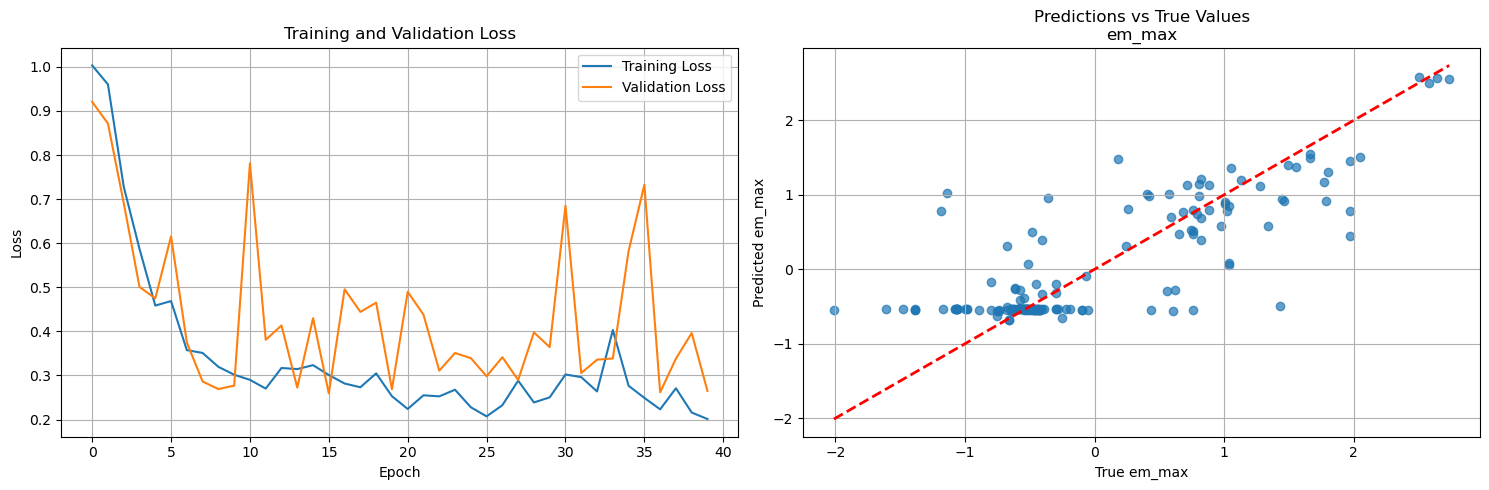


Model saved as 'lstm_model_em_max_embeddings.pth'


In [ ]:
"""Main training pipeline."""
TARGET_PROPERTY = 'em_max'  # Change this to predict different properties

# Available properties from your dataset:
# brightness, ex_max, em_max, ext_coeff, lifetime, maturation, pka, stokes_shift, qy, agg, switch_type

# Hyperparameters
MAX_LENGTH = 238
NUM_EPOCHS = 40
LEARNING_RATE = 0.001

sample_batch = next(iter(train_loader))[0]
embedding_dim = sample_batch.shape[-1]

# Instantiate the new model
# выбор между EmbeddingLSTM и ProteinLSTM
model = EmbeddingLSTM(
    embed_dim=embedding_dim,
    hidden_size=128,
    num_layers=2,
    dropout_rate=0.1
).to(device)

# Train the model
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model
torch.save(trained_model.state_dict(), f'weights/lstm_model_{TARGET_PROPERTY}_embeddings.pth')
print(f"\nModel saved as 'lstm_model_{TARGET_PROPERTY}_embeddings.pth'")


### Работа с CNN + ESM C

Training on cpu
Number of parameters: 833,329


Epoch 1/100:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/100: 100%|██████████| 17/17 [00:02<00:00,  6.27it/s]


Epoch 5/100
Train Loss: 0.6529, Val Loss: 0.5854
Learning Rate: 0.000100
--------------------------------------------------


Epoch 10/100: 100%|██████████| 17/17 [00:02<00:00,  6.32it/s]


Epoch 10/100
Train Loss: 0.4073, Val Loss: 0.4168
Learning Rate: 0.000100
--------------------------------------------------


Epoch 15/100: 100%|██████████| 17/17 [00:02<00:00,  6.25it/s]


Epoch 15/100
Train Loss: 0.3253, Val Loss: 0.3040
Learning Rate: 0.000100
--------------------------------------------------


Epoch 20/100: 100%|██████████| 17/17 [00:02<00:00,  6.17it/s]


Epoch 20/100
Train Loss: 0.2766, Val Loss: 0.3194
Learning Rate: 0.000100
--------------------------------------------------


Epoch 25/100: 100%|██████████| 17/17 [00:02<00:00,  6.08it/s]


Epoch 25/100
Train Loss: 0.2409, Val Loss: 0.3159
Learning Rate: 0.000100
--------------------------------------------------


Epoch 30/100: 100%|██████████| 17/17 [00:02<00:00,  6.30it/s]


Epoch 30/100
Train Loss: 0.2494, Val Loss: 0.4179
Learning Rate: 0.000100
--------------------------------------------------


Epoch 35/100: 100%|██████████| 17/17 [00:02<00:00,  6.28it/s]


Epoch 35/100
Train Loss: 0.2119, Val Loss: 0.4186
Learning Rate: 0.000100
--------------------------------------------------


Epoch 40/100: 100%|██████████| 17/17 [00:02<00:00,  6.57it/s]


Epoch 40/100
Train Loss: 0.1996, Val Loss: 0.2183
Learning Rate: 0.000100
--------------------------------------------------


Epoch 45/100: 100%|██████████| 17/17 [00:02<00:00,  6.06it/s]


Epoch 45/100
Train Loss: 0.1889, Val Loss: 0.2696
Learning Rate: 0.000100
--------------------------------------------------


Epoch 50/100: 100%|██████████| 17/17 [00:02<00:00,  6.17it/s]


Epoch 50/100
Train Loss: 0.1790, Val Loss: 0.3938
Learning Rate: 0.000100
--------------------------------------------------


Epoch 55/100: 100%|██████████| 17/17 [00:02<00:00,  6.15it/s]


Epoch 55/100
Train Loss: 0.1631, Val Loss: 0.2763
Learning Rate: 0.000100
--------------------------------------------------


Epoch 60/100: 100%|██████████| 17/17 [00:02<00:00,  6.32it/s]


Epoch 60/100
Train Loss: 0.1723, Val Loss: 0.2329
Learning Rate: 0.000100
--------------------------------------------------


Epoch 65/100: 100%|██████████| 17/17 [00:02<00:00,  6.13it/s]


Epoch 65/100
Train Loss: 0.2084, Val Loss: 0.3884
Learning Rate: 0.000100
--------------------------------------------------


Epoch 70/100: 100%|██████████| 17/17 [00:02<00:00,  6.06it/s]


Epoch 70/100
Train Loss: 0.1499, Val Loss: 0.4039
Learning Rate: 0.000100
--------------------------------------------------


Epoch 75/100: 100%|██████████| 17/17 [00:02<00:00,  5.89it/s]


Epoch 75/100
Train Loss: 0.1524, Val Loss: 0.2339
Learning Rate: 0.000100
--------------------------------------------------


Epoch 80/100: 100%|██████████| 17/17 [00:02<00:00,  5.71it/s]


Epoch 80/100
Train Loss: 0.1509, Val Loss: 0.3753
Learning Rate: 0.000100
--------------------------------------------------


Epoch 85/100: 100%|██████████| 17/17 [00:03<00:00,  5.44it/s]


Epoch 85/100
Train Loss: 0.1349, Val Loss: 0.2921
Learning Rate: 0.000100
--------------------------------------------------


Epoch 90/100: 100%|██████████| 17/17 [00:03<00:00,  5.46it/s]


Epoch 90/100
Train Loss: 0.1280, Val Loss: 0.2156
Learning Rate: 0.000100
--------------------------------------------------


Epoch 95/100: 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]


Epoch 95/100
Train Loss: 0.1441, Val Loss: 0.3513
Learning Rate: 0.000100
--------------------------------------------------


Epoch 100/100: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]


Epoch 100/100
Train Loss: 0.1139, Val Loss: 0.2746
Learning Rate: 0.000100
--------------------------------------------------

Test MSE: 0.2910
Test MAE: 0.3545
Test R²:  0.6749


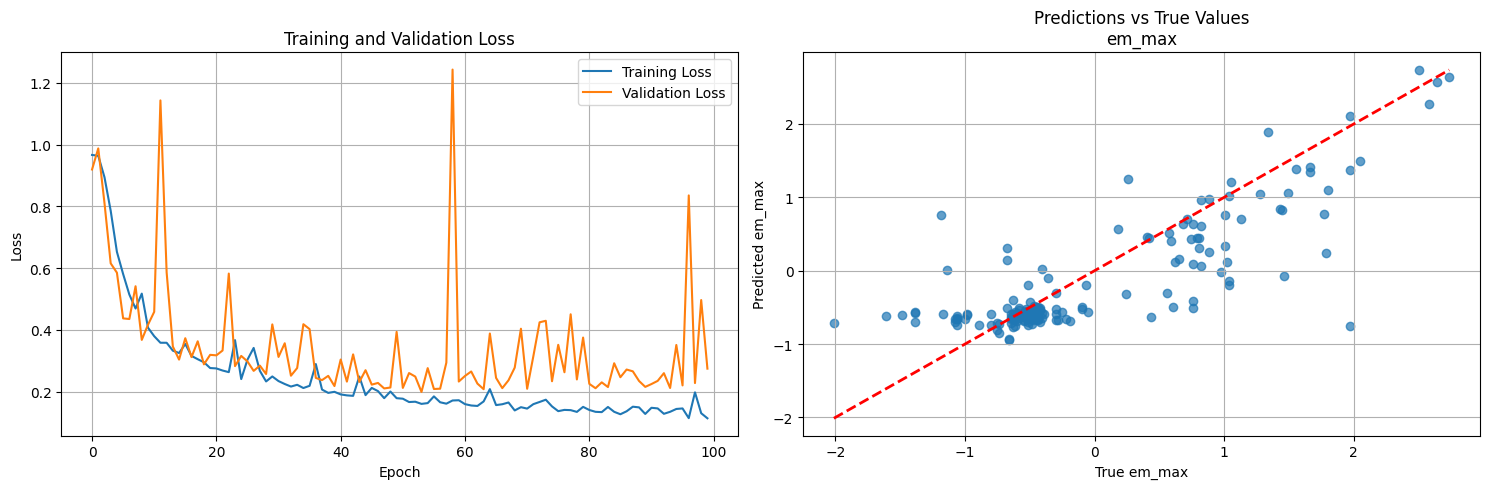

In [ ]:
TARGET_PROPERTY = 'em_max'

BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001

model = EmbeddingsCNN().to(device)

trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

predictions, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

plot_results(train_losses, val_losses, predictions, true_values, TARGET_PROPERTY)

torch.save(trained_model.state_dict(), f'weights/cnn_model_{TARGET_PROPERTY}_custom.pth')
# print(f"Модель сохранена как 'cnn_model_{TARGET_PROPERTY}_custom.pth'")


### Работа с CNN

Training on cuda
Number of parameters: 487,041


Epoch 5/200: 100%|██████████| 17/17 [00:00<00:00, 52.87it/s]


Epoch 5/200
Train Loss: 0.4986, Val Loss: 31.9769
Learning Rate: 0.001000
--------------------------------------------------


Epoch 10/200: 100%|██████████| 17/17 [00:00<00:00, 56.39it/s]


Epoch 10/200
Train Loss: 0.5687, Val Loss: 0.2850
Learning Rate: 0.001000
--------------------------------------------------


Epoch 15/200: 100%|██████████| 17/17 [00:00<00:00, 55.75it/s]


Epoch 15/200
Train Loss: 0.2993, Val Loss: 10.2168
Learning Rate: 0.001000
--------------------------------------------------


Epoch 20/200: 100%|██████████| 17/17 [00:00<00:00, 57.28it/s]


Epoch 20/200
Train Loss: 0.2962, Val Loss: 0.3315
Learning Rate: 0.001000
--------------------------------------------------


Epoch 25/200: 100%|██████████| 17/17 [00:00<00:00, 52.06it/s]


Epoch 25/200
Train Loss: 0.3420, Val Loss: 6.1214
Learning Rate: 0.001000
--------------------------------------------------


Epoch 30/200: 100%|██████████| 17/17 [00:00<00:00, 56.33it/s]


Epoch 30/200
Train Loss: 0.2807, Val Loss: 1.4734
Learning Rate: 0.001000
--------------------------------------------------


Epoch 35/200: 100%|██████████| 17/17 [00:00<00:00, 56.64it/s]


Epoch 35/200
Train Loss: 0.1872, Val Loss: 2.5395
Learning Rate: 0.001000
--------------------------------------------------


Epoch 40/200: 100%|██████████| 17/17 [00:00<00:00, 59.14it/s]


Epoch 40/200
Train Loss: 0.1783, Val Loss: 0.2773
Learning Rate: 0.001000
--------------------------------------------------


Epoch 45/200: 100%|██████████| 17/17 [00:00<00:00, 53.15it/s]


Epoch 45/200
Train Loss: 1.4307, Val Loss: 0.2326
Learning Rate: 0.001000
--------------------------------------------------


Epoch 50/200: 100%|██████████| 17/17 [00:00<00:00, 58.93it/s]


Epoch 50/200
Train Loss: 0.2375, Val Loss: 1.0132
Learning Rate: 0.001000
--------------------------------------------------


Epoch 55/200: 100%|██████████| 17/17 [00:00<00:00, 56.38it/s]


Epoch 55/200
Train Loss: 0.1817, Val Loss: 0.9465
Learning Rate: 0.001000
--------------------------------------------------


Epoch 60/200: 100%|██████████| 17/17 [00:00<00:00, 57.61it/s]


Epoch 60/200
Train Loss: 0.1856, Val Loss: 0.7280
Learning Rate: 0.001000
--------------------------------------------------


Epoch 65/200: 100%|██████████| 17/17 [00:00<00:00, 58.03it/s]


Epoch 65/200
Train Loss: 0.1580, Val Loss: 0.2934
Learning Rate: 0.001000
--------------------------------------------------


Epoch 70/200: 100%|██████████| 17/17 [00:00<00:00, 58.96it/s]


Epoch 70/200
Train Loss: 0.1427, Val Loss: 0.2617
Learning Rate: 0.001000
--------------------------------------------------


Epoch 75/200: 100%|██████████| 17/17 [00:00<00:00, 58.17it/s]


Epoch 75/200
Train Loss: 0.3135, Val Loss: 0.2890
Learning Rate: 0.001000
--------------------------------------------------


Epoch 80/200: 100%|██████████| 17/17 [00:00<00:00, 59.04it/s]


Epoch 80/200
Train Loss: 0.1490, Val Loss: 0.4332
Learning Rate: 0.001000
--------------------------------------------------


Epoch 85/200: 100%|██████████| 17/17 [00:00<00:00, 56.98it/s]


Epoch 85/200
Train Loss: 0.1315, Val Loss: 0.2485
Learning Rate: 0.001000
--------------------------------------------------


Epoch 90/200: 100%|██████████| 17/17 [00:00<00:00, 57.92it/s]


Epoch 90/200
Train Loss: 0.1239, Val Loss: 0.2629
Learning Rate: 0.001000
--------------------------------------------------


Epoch 95/200: 100%|██████████| 17/17 [00:00<00:00, 57.29it/s]


Epoch 95/200
Train Loss: 0.1238, Val Loss: 1.7289
Learning Rate: 0.001000
--------------------------------------------------


Epoch 100/200: 100%|██████████| 17/17 [00:00<00:00, 58.91it/s]


Epoch 100/200
Train Loss: 0.1687, Val Loss: 0.2095
Learning Rate: 0.001000
--------------------------------------------------


Epoch 105/200: 100%|██████████| 17/17 [00:00<00:00, 57.24it/s]


Epoch 105/200
Train Loss: 0.2157, Val Loss: 0.3326
Learning Rate: 0.001000
--------------------------------------------------


Epoch 110/200: 100%|██████████| 17/17 [00:00<00:00, 60.68it/s]


Epoch 110/200
Train Loss: 0.1271, Val Loss: 0.2816
Learning Rate: 0.001000
--------------------------------------------------


Epoch 115/200: 100%|██████████| 17/17 [00:00<00:00, 59.33it/s]


Epoch 115/200
Train Loss: 0.1732, Val Loss: 0.2561
Learning Rate: 0.001000
--------------------------------------------------


Epoch 120/200: 100%|██████████| 17/17 [00:00<00:00, 59.57it/s]


Epoch 120/200
Train Loss: 0.1244, Val Loss: 0.8368
Learning Rate: 0.001000
--------------------------------------------------


Epoch 125/200: 100%|██████████| 17/17 [00:00<00:00, 58.81it/s]


Epoch 125/200
Train Loss: 0.1417, Val Loss: 0.6518
Learning Rate: 0.001000
--------------------------------------------------


Epoch 130/200: 100%|██████████| 17/17 [00:00<00:00, 59.70it/s]


Epoch 130/200
Train Loss: 0.1076, Val Loss: 0.7907
Learning Rate: 0.001000
--------------------------------------------------


Epoch 135/200: 100%|██████████| 17/17 [00:00<00:00, 56.47it/s]


Epoch 135/200
Train Loss: 0.1036, Val Loss: 0.2719
Learning Rate: 0.001000
--------------------------------------------------


Epoch 140/200: 100%|██████████| 17/17 [00:00<00:00, 56.80it/s]


Epoch 140/200
Train Loss: 0.1079, Val Loss: 2.7893
Learning Rate: 0.001000
--------------------------------------------------


Epoch 145/200: 100%|██████████| 17/17 [00:00<00:00, 56.86it/s]


Epoch 145/200
Train Loss: 0.0966, Val Loss: 0.3672
Learning Rate: 0.001000
--------------------------------------------------


Epoch 150/200: 100%|██████████| 17/17 [00:00<00:00, 56.76it/s]


Epoch 150/200
Train Loss: 0.1114, Val Loss: 0.2501
Learning Rate: 0.001000
--------------------------------------------------


Epoch 155/200: 100%|██████████| 17/17 [00:00<00:00, 56.12it/s]


Epoch 155/200
Train Loss: 0.1065, Val Loss: 0.2648
Learning Rate: 0.001000
--------------------------------------------------


Epoch 160/200: 100%|██████████| 17/17 [00:00<00:00, 57.81it/s]


Epoch 160/200
Train Loss: 0.1426, Val Loss: 0.3249
Learning Rate: 0.001000
--------------------------------------------------


Epoch 165/200: 100%|██████████| 17/17 [00:00<00:00, 56.70it/s]


Epoch 165/200
Train Loss: 0.0930, Val Loss: 0.2208
Learning Rate: 0.001000
--------------------------------------------------


Epoch 170/200: 100%|██████████| 17/17 [00:00<00:00, 58.20it/s]


Epoch 170/200
Train Loss: 0.2448, Val Loss: 0.2428
Learning Rate: 0.001000
--------------------------------------------------


Epoch 175/200: 100%|██████████| 17/17 [00:00<00:00, 57.01it/s]


Epoch 175/200
Train Loss: 0.0944, Val Loss: 0.2838
Learning Rate: 0.001000
--------------------------------------------------


Epoch 180/200: 100%|██████████| 17/17 [00:00<00:00, 57.62it/s]


Epoch 180/200
Train Loss: 0.1038, Val Loss: 0.2158
Learning Rate: 0.001000
--------------------------------------------------


Epoch 185/200: 100%|██████████| 17/17 [00:00<00:00, 57.11it/s]


Epoch 185/200
Train Loss: 0.1109, Val Loss: 0.2476
Learning Rate: 0.001000
--------------------------------------------------


Epoch 190/200: 100%|██████████| 17/17 [00:00<00:00, 57.08it/s]


Epoch 190/200
Train Loss: 0.1108, Val Loss: 0.2463
Learning Rate: 0.001000
--------------------------------------------------


Epoch 195/200: 100%|██████████| 17/17 [00:00<00:00, 58.32it/s]


Epoch 195/200
Train Loss: 0.1185, Val Loss: 0.3334
Learning Rate: 0.001000
--------------------------------------------------


Epoch 200/200: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s]


Epoch 200/200
Train Loss: 0.0868, Val Loss: 0.3100
Learning Rate: 0.001000
--------------------------------------------------

Test MSE: 0.2748
Test MAE: 0.3867
Test R²:  0.6930


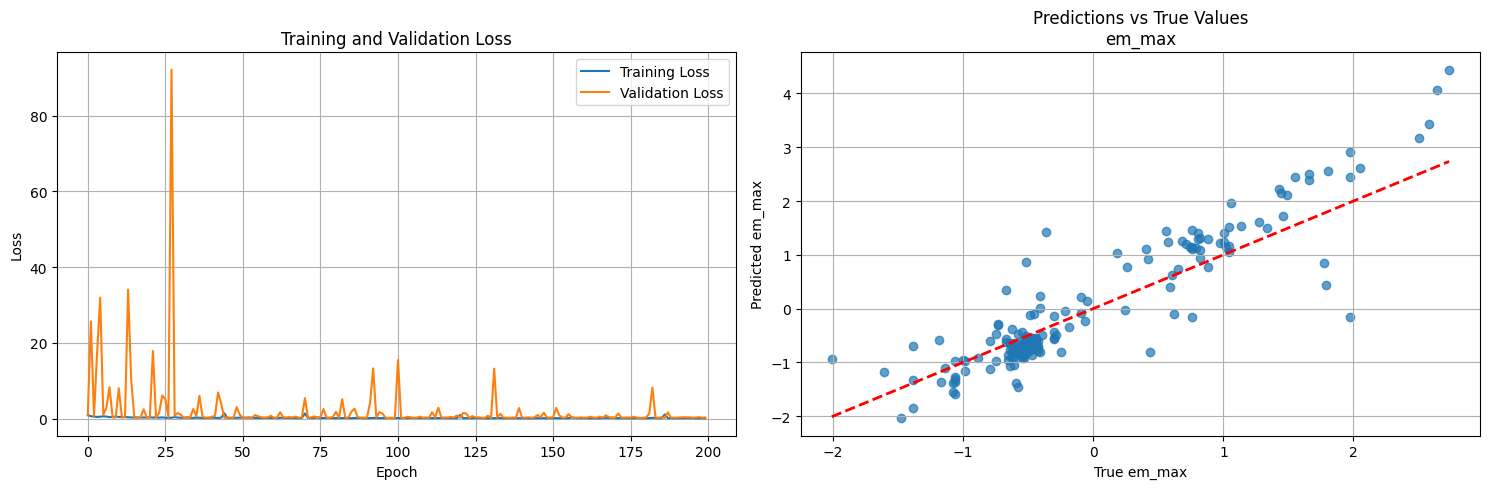


Model saved as 'cnn_model_em_max_onehot.pth'


In [ ]:
"""Main training pipeline."""
TARGET_PROPERTY = 'brightness'  

MAX_LENGTH = 256
BATCH_SIZE = 64
NUM_EPOCHS = 200
LEARNING_RATE = 0.001

model = ProteinCNN(
    num_amino_acids=20, 
    num_filters=128,
    dropout_rate=0.6
)

# Train the model
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model
torch.save(trained_model.state_dict(), f'weights/cnn_model_{TARGET_PROPERTY}_onehot.pth')
print(f"\nModel saved as 'cnn_model_{TARGET_PROPERTY}_onehot.pth'")

In [31]:
trained_model.eval()

predictions = []
true_values = []

with torch.no_grad():
    for sequences, targets in test_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        batch_predictions = model(sequences).squeeze()

        predictions.extend(batch_predictions.cpu().numpy())
        true_values.extend(targets.cpu().numpy())

    # Convert back to original scale
predictions = np.array(predictions)
true_values = np.array(true_values)
s_predictions = dataset.rescale_targets(predictions, TARGET_PROPERTY)
s_true_values = dataset.rescale_targets(true_values, TARGET_PROPERTY)

zv = get_regression_metrics(
    s_predictions,
    s_true_values
)
print(f'\t RMSE: {zv["rmse"]}')
print(f'\t MAE: {zv["mae"]}')
print(f'\t R2: {zv["r2"]}')
print(f'\t MAE (med.): {zv["mae_median"]}')


	 RMSE: 60.79732131958008
	 MAE: 50.817447662353516
	 R2: -0.00016927719116210938
	 MAE (med.): 38.7728271484375


In [32]:
metrics_ci = bootstrap_metric_ci(
    s_predictions, s_true_values, get_regression_metrics, 
    n_bootstrap=1000, alpha=0.05, random_state=42
)

# Print results in a nice format
print("\nMetrics with 95% confidence intervals:")
print(f"RMSE: {(metrics_ci['rmse'][1] + metrics_ci['rmse'][2]) / 2:.2f} +- {(metrics_ci['rmse'][1] + metrics_ci['rmse'][2]) / 2 -metrics_ci['rmse'][1]:.2f}")
print(f"MAE: {(metrics_ci['mae'][1] + metrics_ci['mae'][2]) / 2:.2f} +- {(metrics_ci['mae'][1] + metrics_ci['mae'][2]) / 2 -metrics_ci['mae'][1]:.2f}")
print(f"R2: {(metrics_ci['r2'][1] + metrics_ci['r2'][2]) / 2:.2f} +- {(metrics_ci['r2'][1] + metrics_ci['r2'][2]) / 2 -metrics_ci['r2'][1]:.2f}")
print(f"MAE Median: {(metrics_ci['mae_median'][1] + metrics_ci['mae_median'][2]) / 2:.2f} +- {(metrics_ci['mae_median'][1] + metrics_ci['mae_median'][2]) / 2 -metrics_ci['mae_median'][1]:.2f}")


Metrics with 95% confidence intervals:
RMSE: 61.01 +- 6.72
MAE: 51.21 +- 5.12
R2: -0.02 +- 0.02
MAE Median: 39.50 +- 3.73
